Start with usual things as in Rossmann lesson

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *

In [3]:
path=Path('data/')
train_df = pd.read_pickle(path/'train_clean.zip', compression='zip')
test_df = pd.read_pickle(path/'test_clean')

In [4]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [4]:
n = len(train_df); n

844338

In [87]:
len(train_df),len(test_df)

(844338, 41088)

In [5]:
procs=[FillMissing, Categorify, Normalize]

In [6]:
cat_vars_tpl = ('Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw')

cont_vars_tpl = ('CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday')
cat_vars = list(cat_vars_tpl)
cont_vars = list(cont_vars_tpl)
all_vars = cat_vars + cont_vars

In [7]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [8]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [9]:
valid_idx = range(cut)
valid_idx

range(0, 41395)

In [14]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [10]:
BS = 1024

In [11]:
data_pre =  (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True))
data = data_pre.databunch(bs=BS)

## Model

In [12]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [13]:
np.random.seed(1001)
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


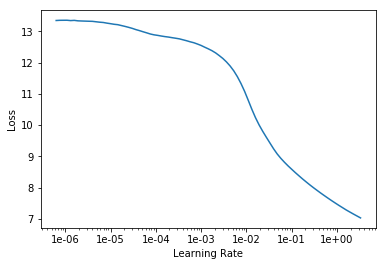

In [50]:
learn.lr_find()
learn.recorder.plot()

In [51]:
learn.fit_one_cycle(6, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.022813,0.023840,0.149339,00:20
1,0.020116,0.016392,0.128023,00:21
2,0.016061,0.014945,0.129059,00:20
3,0.013814,0.015923,0.120301,00:20
4,0.010946,0.011608,0.111478,00:21
5,0.009276,0.011273,0.107872,00:20


In [52]:
learn.fit_one_cycle(6, 1e-4, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.008718,0.011150,0.107673,00:20
1,0.008866,0.011233,0.110091,00:20
2,0.008652,0.011078,0.108543,00:20
3,0.008632,0.011134,0.108107,00:20
4,0.008793,0.011124,0.107912,00:20
5,0.008758,0.011092,0.107849,00:20


In [53]:
# learn.save('lr1e5_for_interp_e1078')

In [14]:
learn = learn.load('lr1e5_for_interp_e1078');

We don't really care that our result is a little bit worse in the 3rd decimal point. It is more than enough for our analysing the data (model)

## RF vs NN

Ok, here is the trick begins.  
I want to feed Random Forest with the exact information my NN layers get. It means that I want to use embedding instead of categories itself.  
By the way, `get_inner_repr` not only turns categorical data into embeddings output and fill NA’s in continuous data, but also Normalizes cat columns, that, strictly speaking, is not necessary for RF, but it makes no harm and is more coherent with real inner representation in NN.

In [15]:
def list_diff(list_1, list_2):
    diff = set(list_1) - set(list_2)
    return [item for item in list_1 if item in diff]

In [16]:
def apply_fill_n_catf(df:DataFrame, data_prep:LabelLists)->DataFrame: 
    '''
    Reapplies FillMissing and Categorify to given dataframe. 
    data_prep is a LabelLists object which you can get if you split standard databunch creation 
    process into two phases. First you apply all the functions  before .databunch e.g.: 
    data_prep = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True))
    data_prep is now a valid LabelLists object
    Then you can apply .databunch as well to get DataBunch object (that is needed for learning process itself)
    e.g.
    data = data_prep.databunch(bs=BS)
    '''
    
    df_copy = df.copy()
    fill, catf = None, None
    is_alone = True if (len(df) == 1) else False

    proc = data_prep.get_processors()[0][0]  
    if (is_alone):
        df_copy = df_copy.append(df_copy.iloc[0])
    
    for prc in proc.procs:
        if (type(prc) == FillMissing):
            fill = prc
        elif (type(prc) == Categorify):
            catf = prc
    if (fill is not None):
        fill.apply_test(df_copy)
        
    if (catf is not None):
        catf.apply_test(df_copy)
        for c in catf.cat_names:
            df_copy[c] = (df_copy[c].cat.codes).astype(np.int64) + 1
        cats = df_copy[catf.cat_names].to_numpy()
    
    # ugly workaround as apperently catf.apply_test doesn't work with lone row
    if (is_alone):
        df_copy = df_copy[:1]

    return df_copy


def get_model_real_input(df:DataFrame, data_prep:LabelLists, bs:int=None)->Tensor:
    
    df_copy = df.copy()
    fill, catf, norm = None, None, None    
    cats, conts = None, None
    is_alone = True if (len(df) == 1) else False
    

    proc = data_prep.get_processors()[0][0]   
    if (is_alone):
        df_copy = df_copy.append(df_copy.iloc[0])
    
    for prc in proc.procs:
        if (type(prc) == FillMissing):
            fill = prc
        elif (type(prc) == Categorify):
            catf = prc
        elif (type(prc) == Normalize):
            norm = prc
    if (fill is not None):
        fill.apply_test(df_copy)
    if (catf is not None):
        catf.apply_test(df_copy)
        for c in catf.cat_names:
            df_copy[c] = (df_copy[c].cat.codes).astype(np.int64) + 1
        cats = df_copy[catf.cat_names].to_numpy()
        
    if (norm is not None):
        norm.apply_test(df_copy)
        conts = df_copy[norm.cont_names].to_numpy().astype('float32')
    
    # ugly workaround as apperently catf.apply_test doesn't work with lone row
    if (is_alone):
        xs = [torch.tensor([cats[0]], device=learn.data.device), torch.tensor([conts[0]], device=learn.data.device)]
    else:
        if (bs is None):
            xs = [torch.tensor(cats, device=learn.data.device), torch.tensor(conts, device=learn.data.device)]
        elif (bs > 0):
            xs = [list(chunks(l=torch.tensor(cats, device=learn.data.device), n=bs)), 
                  list(chunks(l=torch.tensor(conts, device=learn.data.device), n=bs))]

    return xs 


def get_cust_preds(df:DataFrame, data_prep:LabelLists, learn:Learner, bs:int=None, parent=None)->Tensor: 
    '''
    Using existing model to predict output (learn.model) on a new dataframe at once (learn.predict does it for 
    one row which is pretty slow). 
    data_prep is a LabelLists object which you can get if you split standard databunch creation 
    process into two halfs. First you apply all the functions  before .databunch e.g.: 
    data_prep = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True))
    data_prep is now a valid LabelLists object
    Then you can apply .databunch as well to get DataBunch object (that is needed for learning process itself)
    e.g.
    data = data_prep.databunch(bs=BS)
    ''' 
    from fastai.basic_train import _loss_func2activ
    def turn_to_activ(learn, acts):
        activ = _loss_func2activ(learn.loss_func)
        if activ is not None: 
            return to_np(activ(acts))
        else:
            return to_np(acts)
    
    xs = get_model_real_input(df=df, data_prep=data_prep, bs=bs) 
    learn.model.eval();
    if (bs is None):
        outp = learn.model(x_cat=xs[0], x_cont=xs[1])
        
    elif (bs > 0):
        res = []
        for ca, co in zip(xs[0], xs[1]):
            res.append(learn.model(x_cat=ca, x_cont=co))
        outp = np.concatenate(res, axis=0)
    return turn_to_activ(learn=learn, acts=outp)    


def convert_dep_col(df:DataFrame, dep_col:AnyStr, learn:Learner, data_prep:LabelLists)->Tensor:
    '''
    Converts dataframe column, named "depended column", into tensor, that can later be used to compare with predictions.
    Log will be applied if it was done in a training dataset
    '''
    actls = df[dep_col].T.to_numpy()[np.newaxis].T.astype('float32')
    actls = np.log(actls) if (hasattr(data_prep, 'log') and data_prep.log) else actls
    return torch.tensor(actls, device=learn.data.device)


def calc_loss(func:Callable, pred:Tensor, targ:Tensor, device=None)->Rank0Tensor:
    '''
    Calculates error from predictions and actuals with a given metrics function
    '''
    if (device is None):
        return func(pred, targ)
    else:        
        return func(torch.tensor(pred, device=device), targ)


def calc_error(df:DataFrame, data_prep:LabelLists, learn:Learner, dep_col:AnyStr, 
               func:Callable, bs:int=None)->float:
    '''
    Wrapping function to calculate error for new dataframe on existing learner (learn.model)
    See following functions' docstrings for details
    '''
    preds = get_cust_preds(df=df, data_prep=data_prep, learn=learn, bs=bs)
    actls = convert_dep_col(df, dep_col, learn, data_prep)
    error = calc_loss(func, pred=preds, targ=actls, device=learn.data.device)
    return float(error)

`get_cust_preds` is easely the most useful (and used) function in whole notebook  
It just gives the prediction on a new dataset. Unfortunately there are no such function it fastai itself :(  
There could be a lot of reasons for getting predictions on another set of data (dataframe).  
The obvious one is when you just want to predict on a new dataset, when you want preditions themselves.
The second group of reasons lays in the field of data exploration. What if we would like to do some feature importance or partial dependence analysis (and we do want it), in each of these cases we need an instrument to get predictions on a bunch of new (altered) dataframes.   
Definitely we can use learn.predict(row) for each of well… row in each of dataframe, but it is a pretty long process (in fact in my setup learn.predict in for-loop for 200 rows lasts 45+ seconds, and the process of calculating error for whole dataframe consists of 10,000 rows with `get_cust_preds` take less than a second.


In [17]:
def emb_fwrd_sim(model, x_cat:Tensor, x_cont:Tensor)->Tensor:
    '''
    Part that was completely taking from fastai Tabular model source :)
    Gets inner representation of input dataframe (Catigorified, Filled and Normalized) 
    and process it with embeddings 'prelayer'. Also continuous variables are processed with BatchNorm if needed.
    As a result output is model gets on it's layers as input (embedding in fact are not layers, but before them)
    '''
    if model.n_emb != 0:
        x = [e(x_cat[:,i]) for i,e in enumerate(model.embeds)]
        x = torch.cat(x, 1)
        x = model.emb_drop(x)
    if model.n_cont != 0:
        x_cont = model.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1) if model.n_emb != 0 else x_cont
    return x


def get_inner_repr(df:DataFrame, data_prep:LabelLists, learn:Learner)->Tensor: 
    '''
    Gets new dataframe that has categorical and continuous columns the learner war learnt with 
    (are being taken from learner automatically)
    And outputs inner representation of these data -- what model gets after embeddings
    Is useful for ex. to use learnt embeddings in random forest
    This output can be directly feed to RF learner (after turning it to numpy if needed)
    '''
    xs = get_model_real_input(df=df, data_prep=data_prep)
    return emb_fwrd_sim(model=learn.model, x_cat=xs[0], x_cont=xs[1])    

In [102]:
from sklearn.ensemble import RandomForestRegressor

In [93]:
ln = len(df)

In [94]:
train_idx = list_diff(list_1=range(ln), list_2=valid_idx)

I'd like to keep here saparate dataframes for training and for validation

In [95]:
tr_df = df.iloc[train_idx]
val_df = df.iloc[valid_idx]

#### RF with embeddings

In [56]:
tr_data_inner = to_np(get_inner_repr(df=tr_df[all_vars], data_prep=data_pre, learn=learn))
val_data_inner = to_np(get_inner_repr(df=val_df[all_vars], data_prep=data_pre, learn=learn))

In [59]:
X_train = tr_data_inner
y_train = np.log(tr_df[dep_var].to_numpy())
len(X_train), len(y_train)

(802943, 802943)

In [61]:
X_valid = val_data_inner
y_valid = np.log(val_df[dep_var].to_numpy())
len(X_valid), len(y_valid)

(41395, 41395)

In [110]:
def print_score(m, func):
    print(f'Train error is {func(torch.tensor(m.predict(X_train)), torch.tensor(y_train))}')
    print(f'Validation error is {func(torch.tensor(m.predict(X_valid)), torch.tensor(y_valid))}')          
    print(f'Train score is {m.score(torch.tensor(X_train), torch.tensor(y_train))}')
    print(f'Validation score is {m.score(torch.tensor(X_valid), torch.tensor(y_valid))}')

In [63]:
#Takes me 6 min to run
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=False)
m.fit(X_train, y_train)
print_score(m=m, func=exp_rmspe)

Train error is 0.08195727733872692
Validation error is 0.1432177555725006
Train score is 0.9812742247028636
Validation score is 0.8864854717684789


#### Pure RF

First we should categorify and fill missing values for Random Forest to learn.  
Here we can use functions we already have

In [105]:
X_train = apply_fill_n_catf(df=tr_df[all_vars], data_prep=data_pre).to_numpy()
y_train = np.log(tr_df[dep_var].to_numpy())
len(X_train), len(y_train)

(802943, 802943)

In [106]:
X_valid = apply_fill_n_catf(df=val_df[all_vars], data_prep=data_pre).to_numpy()
y_valid = np.log(val_df[dep_var].to_numpy())
len(X_valid), len(y_valid)

(41395, 41395)

In [111]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=False)
m.fit(X_train, y_train)
print_score(m=m, func=exp_rmspe)

Train error is 0.09763115220772813
Validation error is 0.14379579832970107
Train score is 0.9704807588238801
Validation score is 0.8909713911290575


As you see pure RF worked here pretty the same as with embeddings :(   
Pure NN itself is still much better than any of RF :) 

## Feature importance (naive)

Ok, now we will try to understand how importatnt are the features  
How do we do that? It's a cool trick.  
With existing model we can simply randomize the column we want to test, and calculate what will be the new error (accuracy)  
Now we know our base error and error with one column randomized and (you guessed it) the amount of enlarging this error shows us how important feature is.

In [18]:
def calc_error_mixed_col(df:DataFrame, 
                         data_prep:LabelLists, 
                         learn:Learner, 
                         dep_col:AnyStr, 
                         sampl_col:AnyStr, 
                         func:Callable,
                         bs:int=None,
                         rounds=5)->float:
    df_temp = pd.concat([df]*rounds, ignore_index=True).copy()
    df_temp[sampl_col] = np.random.permutation(df_temp[sampl_col].values)
    return calc_error(df=df_temp, data_prep=data_prep, learn=learn, dep_col=dep_col, func=func, bs=bs)


def get_columns(data_prep:LabelLists)->tuple:
    cats, cats_temp, conts, conts_temp = [], [], [], []
    proc = data_prep.get_processors()[0][0]       
    for prc in proc.procs:
        if (type(prc) == Categorify):
            cats_temp = prc.cat_names
        elif (type(prc) == Normalize):
            conts = prc.cont_names
            
    #delete _na columns
    conts_temp = [cont+'_na' for cont in conts]
    for cat in cats_temp:
        if (cat not in conts_temp):
             cats.append(cat) 
    
    return cats, conts


def calc_feat_importance(df:DataFrame, 
                         data_prep:LabelLists, 
                         learn:Learner, 
                         dep_col:AnyStr,
                         func:Callable,
                         bs:int=None,
                         rounds=5)->OrderedDict:
    
    base_error = calc_error(df=df, data_prep=data_prep, learn=learn, dep_col=dep_col, func=func, bs=bs)
    cats, conts = get_columns(data_prep)
    importance = {}
    pbar = master_bar(cats+conts, total=len(cats+conts))
    for col in pbar:
        importance[col] = calc_error_mixed_col(df=df, data_prep=data_prep, learn=learn, dep_col=dep_col, 
                                               sampl_col=col, func=func, bs=bs, rounds=rounds)
        _ = progress_bar(range(1), display=False, parent=pbar) #looks like fastprogress doesn't work without 2nd bar :(
    for key, value in importance.items():
        importance[key] = (value - base_error)/base_error
    return collections.OrderedDict(sorted(importance.items(), key=lambda kv: kv[1], reverse=True))

In [84]:
#Takes me 16 min to run
feat = calc_feat_importance(df=df, 
                     data_prep=data_pre, 
                     learn=learn, 
                     dep_col=dep_var, 
                     func=exp_rmspe, 
                     bs=204800,
                     rounds=5)
feat

OrderedDict([('Store', 2.7752134208337362),
             ('Promo', 0.8845676767547609),
             ('DayOfWeek', 0.43007899025606494),
             ('State', 0.2258095143853605),
             ('StoreType', 0.16391973889960224),
             ('Day', 0.15572013064943885),
             ('CompetitionDistance', 0.1554957910318926),
             ('Promo_fw', 0.15135729285537958),
             ('Promo_bw', 0.11064122675124458),
             ('Week', 0.09965946372048601),
             ('Year', 0.09824481683400214),
             ('Assortment', 0.053448078928612766),
             ('Month', 0.04274113431492492),
             ('Max_TemperatureC', 0.04184434838310871),
             ('StateHoliday', 0.027824792190042278),
             ('trend_DE', 0.024144801823954565),
             ('StateHoliday_bw', 0.023991647810274526),
             ('BeforeStateHoliday', 0.0235004098897606),
             ('Mean_Humidity', 0.022035761319059696),
             ('Min_Humidity', 0.021181056957357437),
           

Wonderful, now we know it (not really) we can move on to Partial Dependence (no)

The first point that hinted me that it is not ok to do that with NN with embeddings was the *crazy difference in importances* between features (in my other case it was even bigger)  
I was looking at the data and could not believe how the features that must be pretty important for the case are in the bottom of this list (it was the case from field I knew a lot about)  
And then I noticed that pretty all important features are categorical columns and visa versa
And when I (using editable installs) shifted max embedding size to 10 (from up to 600) this gap became much less.  
So it became pretty clear for me why embeddings (categorical columns) seem to be more valuable. Each continuous variable is presented with 1 float number. And each categorical -- with a vector of several dozens. And when we randomize categorical column, we mess with tens of columns rather with one. Which, obviously, is more harmful for accuracy

What do we do?
Will will use the next (much more computational expensive) option.  
I sadly present you the process which involves *retraining NN* for each column (group of columns)

The idea is very simple. We just throw away the column completely, retrain the NN and compare the errors

## True feature importance

In [19]:
from fastai.callbacks import CSVLogger

In [3]:
def clear_pbar():
    # Just to clear the output. Yes, I know, I agree It's awfull should be refactored
    for _ in progress_bar(range(1), parent=None, leave=False):
        1==1    

def extract_metrics_median(metrics_df:DataFrame, acc_func:Callable, bottom_X:float=0.1)->float:
    func_name = acc_func.__name__    
    metr = metrics_df[func_name].to_numpy()
    subset = metr[np.argsort(metr)][-math.ceil(len(metr)*bottom_X):] if (func_name =='accuracy') else metr[np.argsort(metr)][:math.ceil(len(metr)*bottom_X)]
    metrics = np.median(subset)
    return float(metrics)
    
def calc_valid_acc(learn:Learner, func:Callable)->float:
    metr = learn.csv_logger.read_logged_file()
    acc = extract_metrics_median(metrics_df=metr, acc_func=func)  
    return float(acc)

def calc_acc(df:DataFrame, 
             bs:int, 
             acc_func:Callable,
             dep_var:str,
             to_drop_cat:tuple=(), 
             to_drop_cont:tuple=(), 
             load_learn:str=None,
             trains:int=2, 
             cycles:int=80, 
             is_overall_mode:bool=None)->float:
    
    cat_vars_mod = list_diff(CAT_VARS_CONST, to_drop_cat)
    cont_vars_mod = list_diff(CONT_VARS_CONST, to_drop_cont)
    np.random.seed(1001)
    data_pre =  (TabularList.from_df(df, path=path, cat_names=cat_vars_mod, cont_names=cont_vars_mod, procs=procs)
                       .split_by_idx(VALID_IDX)
                       .label_from_df(cols=dep_var, label_cls=FloatList, log=True))
    data = data_pre.databunch(bs=bs)
    learn = tabular_learner(data, 
                            layers=LAYERS, 
                            ps=PS, 
                            emb_drop=EMB_DROP, 
                            y_range=y_range, 
                            metrics=acc_func, 
                            callback_fns=[CSVLogger])
    if (load_learn is not None):
        learn = learn.load(load_learn)
    else:
        for i in range(trains):
            print(f"Train {i+1} of {trains}")
            learn.fit_one_cycle(cycles, 3e-3, wd=0.2);
            clear_pbar()    
    if (is_overall_mode is None) or (is_overall_mode == False):
        acc = calc_valid_acc(learn=learn, func=acc_func)
    else:
        acc = calc_error(df=df, data_prep=data_pre, learn=learn, dep_col=dep_var, func=acc_func, bs=bs)
    return acc

def calc_1_imp_relearn(base_error:float, 
                       df:DataFrame, 
                       bs:int, 
                       acc_func:Callable,
                       dep_var:str, 
                       to_drop_cat:tuple=(), 
                       to_drop_cont:tuple=(), 
                       load_learn:str=None, 
                       trains:int=2, 
                       cycles:int=80, 
                       is_overall_mode:bool=None)->float:
    error = calc_acc(df, bs, acc_func, dep_var, to_drop_cat, to_drop_cont, load_learn, 
                     trains=trains, cycles=cycles, is_overall_mode=is_overall_mode)
    if (acc_func.__name__ == 'accuracy'):
        base_acc, accuracy = base_error, error # Just rename for better understanding
        importance = (base_acc - accuracy)/base_acc
    else:
        importance = (error - base_error)/base_error
    return (list(to_drop_cat)+list(to_drop_cont), importance)

def print_importance_res(dropped:List, importance:float):
    print('Features '+', '.join(dropped)+' have accumulated importance of')
    print(importance)
    
def calc_many_imps_relearn(base_error:float, 
                           df:DataFrame, 
                           bs:int, 
                           acc_func:Callable, 
                           dep_var:str, 
                           to_drop_cats:tuple=(), 
                           to_drop_conts:tuple=(),
                           load_learn:str=None, 
                           trains:int=2, 
                           cycles:int=80, 
                           is_overall_mode:bool=None)->float:
    
    to_drop_cats = listify(to_drop_cats)
    to_drop_conts = listify(to_drop_conts)
    importances = {}
    
    i = 1
    overall = len(list(to_drop_cats)+list(to_drop_conts))
    for var in to_drop_cats:
        var = listify(var)
        print(f"Categorical feature {i} of {len(to_drop_cats)}")
        imp = calc_1_imp_relearn(base_error, df, bs, acc_func, 
                                 dep_var=dep_var, to_drop_cat=var, trains=trains, 
                                 cycles=cycles, is_overall_mode=is_overall_mode)
        key = imp[0] if isinstance(imp[0], str) else ', '.join(str(e) for e in imp[0])
        importances[key] = imp
        i = i + 1
        
    for var in to_drop_conts:
        var = listify(var)
        print(f"Continuous feature {i} of {len(to_drop_conts)}")
        imp = calc_1_imp_relearn(base_error, df, bs, acc_func, 
                                  dep_var=dep_var, to_drop_cont=var, trains=trains, 
                                 cycles=cycles, is_overall_mode=is_overall_mode)
        key = imp[0] if isinstance(imp[0], str) else ', '.join(str(e) for e in imp[0])
        importances[key] = imp
        i = i + 1
    
    return importances

In [31]:
def calc_mean_dict(lst):
    mean_dict = {}
    ln = len(lst)
    for key, value in lst[0].items():
        mean_dict[key] = np.zeros(ln)
    for i, row in enumerate(lst):
        for key, value in row.items():
            mean_dict[key][i] = value[1]
    for key, value in mean_dict.items():
        mean_dict[key] = np.median(value)
            
    return mean_dict


def calc_many_imps_relearn_steps(base_error:float,
                                 df:DataFrame,
                                 bs:int,
                                 acc_func:Callable,
                                 dep_var:str,
                                 to_drop_cats:tuple=(),
                                 to_drop_conts:tuple=(),
                                 load_learn:str=None,
                                 trains=2,
                                 cycles=80,
                                 rounds=5,
                                 is_overall_mode:bool=None)->dict:
    '''
    to_drop_cats and to_drop_conts:tuple can be tupple of tuples (lists of lists)
    this means we measure every item in the first list and retrain without every item in the second one in one turn
    (treat it as one entity)
    '''
    acc = []
    for i in range(rounds):
        print(f"Round {i+1} of {rounds}")
        acc_ = calc_many_imps_relearn(base_error=base_error,
                                      df=df,
                                      bs=bs,
                                      acc_func=acc_func,
                                      dep_var=dep_var,
                                      to_drop_cats=to_drop_cats,
                                      to_drop_conts=to_drop_conts,
                                      trains=trains,
                                      cycles=cycles,
                                      is_overall_mode=is_overall_mode)
        acc.append(acc_)
    imp = calc_mean_dict(acc)
    return collections.OrderedDict(sorted(imp.items(), key=lambda kv: kv[1], reverse=True))


def calc_base_acc_steps(df:DataFrame, 
                        bs:int, 
                        acc_func:Callable, 
                        dep_var:str,
                        trains=2, 
                        cycles=80,
                        rounds=5, 
                        is_overall_mode:bool=None)->float:
    base_acc=np.empty((rounds))
    for i in range(rounds):
        print(f"Round {i+1} of {rounds}")
        base_acc[i] = calc_acc(df=df, bs=BS, 
                               acc_func=acc_func, dep_var=dep_var, trains=trains, 
                               cycles=cycles, is_overall_mode=is_overall_mode)
    return np.median(base_acc)

These are the parameters used in learner creation

In [29]:
CAT_VARS_CONST = cat_vars_tpl
CONT_VARS_CONST = cont_vars_tpl
LAYERS = [1000, 500] 
PS = [0.01, 0.1]
EMB_DROP = 0.04
VALID_IDX = valid_idx
is_overall_mode = True
BS = 1024

And these are the hyperparameters that are used in training.  
What are they?
`cycles` is the common thing you already know  
`rounds` is a new one. It just sets how many times the whole process will be repeated (and then median of results is taken). 
It reduces instability of results a lot. The more, the better accuracy in feature importance you will get (now I think that 3 is not big enough, maybe 5)  
There is also one optional parameter `trains` I've defaulted it to 2. It just means that I train NN in 2 `fit.one_cycle`-s by (in this case) 6 cycles each.  
So it gives us overall 36 = 6(cycles)\*2(trains)\*3(rounds) cycles for every feature we test.

In [30]:
rounds = 3
acc_func = exp_rmspe
cycles = 6

In [31]:
# 12 mins
base_error = calc_base_acc_steps(df=df, bs=BS, acc_func=acc_func, dep_var=dep_var, 
                                 cycles=cycles, rounds=rounds, is_overall_mode=is_overall_mode)

In [37]:
base_error

0.14800025522708893

In [32]:
each_cat = [[var] for var in cat_vars_tpl]
each_cont = [[var] for var in cont_vars_tpl]

In [114]:
#Takes me 4 hours to run
imp = calc_many_imps_relearn_steps(base_error=base_error, df=df, bs=BS, acc_func=acc_func, 
                                          dep_var=dep_var, to_drop_cats=each_cat, cycles=cycles, 
                                          rounds=rounds, is_overall_mode=is_overall_mode)

In [38]:
imp

OrderedDict([('Store', 0.1647998243115971),
             ('Month', 0.04285088722337317),
             ('State', 0.03870053444338687),
             ('Week', 0.031876485011430054),
             ('StoreType', 0.03168412172177492),
             ('StateHoliday_bw', 0.02653184704373341),
             ('Year', 0.026495619474594116),
             ('Day', 0.02639101874679756),
             ('Promo_fw', 0.02616161149207887),
             ('Promo_bw', 0.02342035807737535),
             ('Assortment', 0.02335984272948915),
             ('Promo2Weeks', 0.022817857885267186),
             ('StateHoliday_fw', 0.02173388819682326),
             ('SchoolHoliday_fw', 0.021512134653894562),
             ('SchoolHoliday_bw', 0.019208775603069116),
             ('Events', 0.0099779909863767),
             ('DayOfWeek', 0.009319669722946858),
             ('PromoInterval', 0.008814320645826323),
             ('StateHoliday', 0.0074109360520134004),
             ('CompetitionOpenSinceYear', 0.007148872960324

In [272]:
import pickle

In [39]:
f = open(path/"ros_imp_cat.pkl","wb")
pickle.dump(imp,f)
f.close()

In [40]:
f = open(path/"ros_imp_cat.pkl","rb")
imp_cat = pickle.load(f)
f.close()

In [41]:
#Takes me 3 hours to run
imp = calc_many_imps_relearn_steps(base_error=base_error, df=df, bs=BS, acc_func=acc_func, 
                                          dep_var=dep_var, to_drop_conts=each_cont, cycles=cycles, 
                                          rounds=rounds, is_overall_mode=is_overall_mode)

In [42]:
imp

OrderedDict([('CompetitionDistance', 0.04865852372961906),
             ('SchoolHoliday', 0.04661477858271014),
             ('Max_TemperatureC', 0.03673995963126254),
             ('trend_DE', 0.03285299658634249),
             ('Mean_Humidity', 0.03172902349760954),
             ('Min_Humidity', 0.029926421296830638),
             ('Max_Wind_SpeedKm_h', 0.023433114263692007),
             ('Promo', 0.02298817848496714),
             ('Mean_TemperatureC', 0.01780335001944553),
             ('CloudCover', 0.014182634095326675),
             ('AfterStateHoliday', 0.010270668925225991),
             ('Mean_Wind_SpeedKm_h', 0.0099141080053029),
             ('trend', 0.00635053979588265),
             ('Min_TemperatureC', 0.004895109961897782),
             ('Max_Humidity', -0.0028304446694295544),
             ('BeforeStateHoliday', -0.012495347818850316)])

In [43]:
f = open(path/"ros_imp_cont.pkl","wb")
pickle.dump(imp,f)
f.close()

In [44]:
f = open(path/"ros_imp_cont.pkl","rb")
imp_cont = pickle.load(f)
f.close()

In [46]:
imp_merged = {**dict(imp_cat), **dict(imp_cont)}
imp_merged = collections.OrderedDict(sorted(imp_merged.items(), key=lambda kv: kv[1], reverse=True))
imp_merged

OrderedDict([('Store', 0.1647998243115971),
             ('CompetitionDistance', 0.04865852372961906),
             ('SchoolHoliday', 0.04661477858271014),
             ('Month', 0.04285088722337317),
             ('State', 0.03870053444338687),
             ('Max_TemperatureC', 0.03673995963126254),
             ('trend_DE', 0.03285299658634249),
             ('Week', 0.031876485011430054),
             ('Mean_Humidity', 0.03172902349760954),
             ('StoreType', 0.03168412172177492),
             ('Min_Humidity', 0.029926421296830638),
             ('StateHoliday_bw', 0.02653184704373341),
             ('Year', 0.026495619474594116),
             ('Day', 0.02639101874679756),
             ('Promo_fw', 0.02616161149207887),
             ('Max_Wind_SpeedKm_h', 0.023433114263692007),
             ('Promo_bw', 0.02342035807737535),
             ('Assortment', 0.02335984272948915),
             ('Promo', 0.02298817848496714),
             ('Promo2Weeks', 0.022817857885267186),
     

In [47]:
f = open(path/"ros_imp_merged.pkl","wb")
pickle.dump(imp_merged,f)
f.close()

In [48]:
f = open(path/"ros_imp_merged.pkl","rb")
imp_merged = pickle.load(f)
f.close()

----------------------------------------------------------

Now let's try to test all columns at once

In [33]:
#Takes me 8 hours to run
imp = calc_many_imps_relearn_steps(base_error=base_error, df=df, bs=BS, acc_func=acc_func, 
                                          dep_var=dep_var, to_drop_cats=each_cat, to_drop_conts=each_cont, 
                                          cycles=cycles, rounds=rounds, is_overall_mode=is_overall_mode)

In [34]:
imp

OrderedDict([('Store', 0.135575061499906),
             ('DayOfWeek', 0.03104379735704198),
             ('Max_TemperatureC', 0.029381313915677092),
             ('Max_Wind_SpeedKm_h', 0.0258247753326603),
             ('State', 0.02553913667452366),
             ('Promo2SinceYear', 0.02393384137479487),
             ('PromoInterval', 0.02128868845742942),
             ('BeforeStateHoliday', 0.019680976757349807),
             ('trend_DE', 0.018117666413716534),
             ('CompetitionOpenSinceYear', 0.01799674571282753),
             ('StateHoliday_bw', 0.014162119722770415),
             ('trend', 0.013887455549560421),
             ('CompetitionDistance', 0.013183175530644034),
             ('Month', 0.013041816110121002),
             ('Mean_Humidity', 0.012621966549165843),
             ('Day', 0.010355685070139543),
             ('StateHoliday_fw', 0.00975963965027035),
             ('Assortment', 0.007852092939993026),
             ('Promo_fw', 0.00765284059439824),
         

In [35]:
f = open(path/"ros_imp_all.pkl","wb")
pickle.dump(imp,f)
f.close()

In [36]:
f = open(path/"ros_imp_all.pkl","rb")
imp_all = pickle.load(f)
f.close()

Now you can see how much less retraining method made the importance of 'Store'. It's feels much more explainable.

Also here we still can see some instability in values (between imp_merged man imp), which will be less if we use higher rounds value.
(Don't forget to recalculate base_error after that)

One of the most interesting things here is that we should check the importance of not only one column at a time, but for a number of 'linked' columns (treat it as one entity). It is possible with these functions, but it is extremely time consuming to check all the variants with only 2 columns 'linked'

## Partial Dependence

What partial dependence is?  
In short it shows you how 'important' not the feature itself is, but how particular category affects the dependent variable.  
For ex. we can determine what day of the month sales are the biggest.  
It looks like we can get this info directly from data (without any model). We just make a plot Month vs Sales. But it won't be the 'clean experiment'. What we really want is to calculate category importance all other things being equal.  
How can we do that?  
If we have a model, we can make an experiment. Let's take all our data and set the day column to 1. Now we have a bunch of data of what will be the sales for every Store, every Year etc for this particular Day. And we can take median across all of the dataset (that will be the thing we want -- median Sales on the 1st day of the month, everything other is beeing equal). And then we repeat it for every category (from 2 to 31). Comparing these medians we can determine what category influence Sales the most (and how).

In [32]:
def get_field_uniq_x_coef(df:DataFrame, field:str, coef:float)->list:
    '''
    This function outputs threshold to number of occurrences different variants of list of columns (fields) 
    In short if coef for ex. is 0.9, then function outputs number of occurrences for all but least 10%
    of the least used
    If coef is more 1.0, then 'coef' itself is used as threshold
    ''' 
    if (coef > 1):
        return math.ceil(coef)
    coef = 0. if (coef < 0) else coef
    occs = df.groupby(field).size().reset_index(name="Times").sort_values(['Times'], ascending=False)
    num = math.ceil(coef*len(occs))
    if (num <= 0):
        # number of occurances is now = max_occs+1 (so it will be no items with this filter)
        return occs.iloc[0]['Times'] + 1
    else:
        return occs.iloc[num-1]['Times']

def get_part_dep_one_list(df:DataFrame, data_prep:LabelLists, 
                     learn:Learner, bs:int=None, fields:list=(), coef:float=1.0, to_int:bool=False, 
                     dep_name:str=None, is_sorted:bool=True)->DataFrame:
    '''
    Function calculate partial dependency for column in fields.
    Fields is a list of lists of what columns we want to test. The inner items are treated as connected fields.
    For ex. fields = [['Store','StoreType']] mean that Store and StoreType is treated as one entity 
    (it's values are substitute as a pair, not as separate values)
    coef is useful when we don't want to deal with all the variants, but only with most common
    '''
    if (dep_name is None):
        dep_name = 'dep_var'
    fields = listify(fields)
    df = apply_fill(df=df, data_prep=data_prep)
    
    field_min_occ = get_field_uniq_x_coef(df=df, field=fields, coef=coef)
    occs = df.groupby(fields).size().reset_index(name="Times").sort_values(['Times'], ascending=False)
    occs = occs[occs['Times'] >= field_min_occ]
    df_copy = df.merge(occs[fields]).copy()        
    
    frame = []
    ln = len(occs)
    if (ln > 0):
        pbar = master_bar(occs.iterrows(), total=ln)
        for _, row in pbar:
            # We don't need to do df_copy = df.merge(occs[field]).copy() every time 
            # as every time we change the same column (set of columns)
            record = []
            pb = progress_bar(fields, display=False, parent=pbar)
            for fld in pb:
                df_copy[fld] = row[fld] 
            preds = get_cust_preds(df=df_copy, data_prep=data_pre, learn=learn, bs=bs)
            preds = np.exp(np.median(preds)) if (hasattr(data_prep, 'log') and data_prep.log) else np.median(preds)
            pred = int(preds) if to_int else preds
            for fld in fields:
                record.append(row[fld])
            record.append(pred)
            record.append(row['Times'])
            frame.append(record)
    out = pd.DataFrame(frame, columns=fields+[dep_name, 'times'])
    median = out[dep_name].median()
    out[dep_name] /= median
    if (is_sorted == True):
        out = out.sort_values(by=dep_name, ascending=False)
    return out

def get_cat_cols(data_prep:LabelLists,  is_wo_na=True)->List:
    '''
    Just outputs category fields from LabelLists object
    '''
    catf = None
    result = []
    proc = data_prep.get_processors()[0][0]       
    for prc in proc.procs:
        if (type(prc) == Categorify):
            catf = prc        
    if (catf is not None):
        result = [c for c in catf.cat_names if ((is_wo_na is not None) and (is_wo_na == True) and (c[-3:] != "_na"))]        
    return result


def get_cont_cols(data_prep:LabelLists)->List:
    '''
    Just outputs continuous fields from LabelLists object
    '''
    norm = None
    result = []
    proc = data_prep.get_processors()[0][0]   
    
    for prc in proc.procs:
        if (type(prc) == Normalize):
            norm = prc
        
    if (norm is not None):
        result = norm.cont_names
        
    return result


def get_part_dep(df:DataFrame, data_prep:LabelLists, learn:Learner, bs:int=None, 
                 fields:tuple=None, coef:float=1.0, to_int:bool=False, 
                 dep_name:str=None, is_sorted:bool=True)->List:
    '''
    Makes a datafreme with partial dependencies for every categorical variable in df
    '''
    result = []
    if (fields is None):
        fields = get_cat_cols(data_prep=data_prep)
    
    for field in fields:
        new_df = get_part_dep_one_list(df=df, data_prep=data_prep, 
                                       learn=learn, bs=bs, fields=field, to_int=to_int, 
                                       dep_name=dep_name, coef=coef, is_sorted=is_sorted)
        new_df['feature'] = str(field)
        new_df = new_df.rename(index=str, columns={str(field): "value"})
        result.append(new_df) 
    clear_pbar()
    result = pd.concat(result, ignore_index=True)
    result = result[['feature', 'value', dep_name, 'times']]
    
    return result

part_dep_multi = partial(get_part_dep_one_list, df=df, data_prep=data_pre, learn=learn, bs=BS,
                to_int=True, dep_name=dep_var)

In [96]:
[(cat, len(df[cat].unique())) for cat in cat_vars_tpl]

[('Store', 1115),
 ('DayOfWeek', 7),
 ('Year', 3),
 ('Month', 12),
 ('Day', 31),
 ('StateHoliday', 2),
 ('CompetitionMonthsOpen', 25),
 ('Promo2Weeks', 26),
 ('StoreType', 4),
 ('Assortment', 3),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 23),
 ('Promo2SinceYear', 8),
 ('State', 12),
 ('Week', 52),
 ('Events', 22),
 ('Promo_fw', 6),
 ('Promo_bw', 6),
 ('StateHoliday_fw', 3),
 ('StateHoliday_bw', 3),
 ('SchoolHoliday_fw', 8),
 ('SchoolHoliday_bw', 8)]

In [268]:
#Takes me 23 min to run
prt_dep_all = get_part_dep(df=df, data_prep=data_pre, learn=learn, bs=BS, coef=900, 
             to_int=True, dep_name=dep_var, is_sorted=True)
prt_dep_all

,feature,value,Sales
0,Store,262,1.695036
1,Store,562,1.679361
2,Store,733,1.393489
3,Store,335,1.335410
4,Store,259,1.113947
5,Store,682,1.089731
6,Store,769,1.038686
7,Store,423,1.008039
8,Store,578,1.000000
9,Store,1097,0.919916


In [273]:
f = open(path/"prt_dep_900.pkl","wb")
pickle.dump(prt_dep_all,f)
f.close()

In [40]:
f = open(path/"prt_dep_900.pkl","rb")
prt_dep_all = pickle.load(f)
f.close()

In [299]:
prt_dep_all.query("feature == 'State'")

,feature,value,Sales
162,State,BE,1.030859
163,State,NW,1.010445
164,State,"HB,NI",1.009495
165,State,HH,1.007121
166,State,SN,1.006014
167,State,TH,1.000791
168,State,BY,0.999209
169,State,ST,0.998892
170,State,SH,0.997784
171,State,HE,0.996044


This is a plot of how column 'Day' *alone* affects Sales  
Also remember that it should be 'multiplied' to the 'importance' of this column. Here we just see how values are ordered *inside one category column*

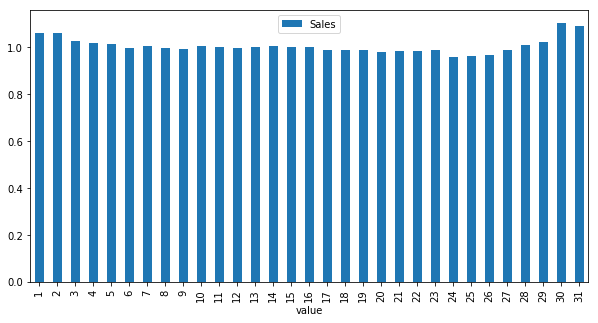

In [288]:
prt_dep_all.query("feature == 'Day'").sort_values('value').plot(x='value', y='Sales', kind='bar', figsize=(10,5))

And this is a plot from data overall (with addition influence from others columns)

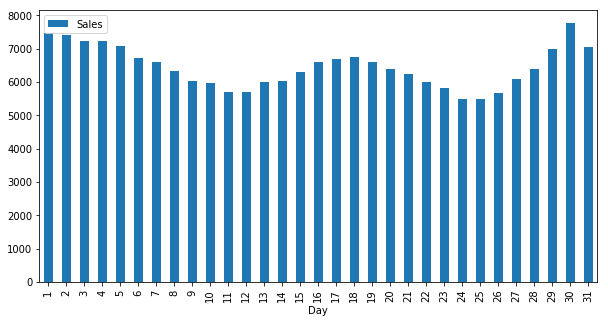

In [42]:
df.groupby('Day').agg('median').reset_index().plot(x='Day', y='Sales', kind='bar', figsize=(10,5))

`times` is given here as an reference to how often this particulat cagegory appears in the data. The more `times` is, the more you can be sure in result

In [250]:
part_dep_multi(fields='Store', coef=900)

,Store,Sales,times
4,262,1.695036,942
3,562,1.679361,942
5,733,1.393489,942
8,335,1.335410,942
11,259,1.113947,931
7,682,1.089731,942
0,769,1.038686,942
9,423,1.008039,942
16,578,1.000000,901
1,1097,0.919916,942


In [243]:
part_dep_multi(fields='StoreType', coef=1)

,StoreType,Sales,times
3,b,1.031688,15560
0,a,1.000000,457042
2,c,1.000000,112968
1,d,0.999527,258768


In [244]:
part_dep_multi(fields='DayOfWeek')

,DayOfWeek,Sales,times
3,5,1.029383,138633
1,2,1.005447,143955
0,6,0.994553,144052
2,3,0.988775,141922


In [183]:
part_dep_multi(fields='State')

,State,Sales,times
4,BE,1.034057,72353
11,"HB,NI",1.015365,17404
10,HH,1.014732,22107
0,NW,1.011088,222930
1,BY,1.004277,111959
2,SH,1.002851,91704
3,HE,0.997149,87730
5,SN,0.996990,58352
6,BW,0.994931,56866
8,RP,0.993822,31242


In [231]:
#Takes me 6 min to run
part_dep_multi(fields='Store', coef=0.05)

,Store,Sales,times
238,817,2.934314,784
187,1114,2.676376,784
4,262,2.439006,942
146,513,2.431649,784
3,562,2.350124,942
218,788,2.349523,784
152,698,2.168156,784
100,320,2.041288,784
42,595,2.036484,784
141,523,1.989640,784


We also can check partial importance of not only one column, but a number of 'linked' columns. That is (linked columns where the value from one column is very (or 100%) correlated with the value in another) often the case for realworld data as we make much denormalization here.  
Even here we see that Store number 'determines' it's type and that's why we should treat it as one entity.
Note here are not absolute values, but the relative ones. So they cannot be compared directly (even variation in number of rows will shift the median, used here as a pivotal point) 

In [44]:
#Takes me 6 min to run
part_dep_multi(fields=['Store','StoreType'], coef=0.05)

,Store,StoreType,Sales,times
238,817,a,3.015124,784
187,1114,a,2.729280,784
4,262,b,2.550363,942
3,562,b,2.534785,942
146,513,a,2.484422,784
218,788,a,2.399123,784
152,698,a,2.207653,784
8,335,b,2.085451,942
100,320,a,2.080309,784
5,733,b,2.054295,942


In [235]:
part_dep_multi(fields='Events')

,Events,Sales,times
16,Fog-Rain-Snow-Hail,1.008632,397
19,Fog-Rain-Hail,1.006277,305
14,Rain-Snow-Hail-Thunderstorm,1.005179,483
2,Fog-Rain,1.004551,74839
17,Fog-Thunderstorm,1.004551,384
1,Fog,1.004237,102706
11,Thunderstorm,1.003766,2208
9,Rain-Hail,1.001412,2824
7,Fog-Snow,1.001099,6657
10,Rain-Snow-Hail,1.000785,2223


In [269]:
#Takes me 2 min to run
part_dep_multi(fields='CompetitionMonthsOpen')

,CompetitionMonthsOpen,Sales,times
1,0,1.012827,346640
21,20,1.009501,4577
24,21,1.006651,4483
19,19,1.005859,4645
16,18,1.004592,4689
0,24,1.004434,386213
17,15,1.003009,4674
12,16,1.002217,4780
23,23,1.001742,4489
20,17,1.001742,4627


We can look at partial dependency not only for all the data, but for a subdata with some condition.
For ex. here we can determine PD for a day for a particular State

In [278]:
get_part_dep_one_list(df=df.query("State == 'BW'"), data_prep=data_pre, learn=learn, bs=BS,
                to_int=True, dep_name=dep_var, fields='Day')

,Day,Sales,times
26,30,1.093658,1758
30,31,1.080278,1099
2,2,1.047089,1973
29,1,1.036664,1267
28,29,1.021894,1616
27,3,1.017897,1693
3,4,1.017029,1973
14,5,1.010947,1901
8,28,1.009557,1904
21,14,1.004865,1830


## Dendrogram and correlation lists

Here we will work not with our model, but with actual data itself. We will try to get correlations out of it, that can, potentialy, help us to get rid of some redundancy and just understand our data better. 

In [23]:
from scipy.cluster import hierarchy as hc

I use here `Cramers V` statistic to determine correlation because my experiments showed me that more simple 
(and muuuuch fast) `Spearman rank-order correlation` algorithm doesn't work well for categorical columns in many cases.  
As an ex.: if you add another column of categorical data, but assign categorical differently (let's randomize order in category dictionary) these column should have 100% correlation, but that's not the case for `spearmanr`.  
So I've shifted to more sophisticated analysis algorithm `Cramers V`.  
Also it can handle NA values without manual preprocessing.

In [24]:
def build_correlation_matr(df:DataFrame):
    '''
    Build Spearman rank-order correlation matrix
    NA in df should be fixed before pass here
    '''
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr[np.isnan(corr)] = 0.0
    np.fill_diagonal(corr, 1.0)
    return corr

def plot_dendrogram_corr(corr_matr, columns, figsize=None, leaf_font_size=16):
    '''
    Plots dendrogram for a given correlation matrix
    '''
    if (figsize is None):
        figsize = (15, 0.02*leaf_font_size*len(df.columns))
    corr_condensed = hc.distance.squareform(1-corr_matr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    dendrogram = hc.dendrogram(z, labels=columns, orientation='left', leaf_font_size=leaf_font_size)
    plt.show()

def plot_dendrogram(df:DataFrame, data_prep:LabelLists, figsize=None, leaf_font_size=16):
    corr = build_correlation_matr(df)
    plot_dendrogram_corr(corr_matr=corr, columns=df.columns, figsize=figsize, leaf_font_size=leaf_font_size)

In [25]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    if (chi2 == 0):
        return 0.0
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def get_cramer_v_matr(df:DataFrame)->np.ndarray:
    '''
    Calculate Cramers V statistic for every pair in df's columns
    '''
    cols = list(df.columns)
    corrM = np.zeros((len(cols), len(cols)))
    pbar = master_bar(list(itertools.combinations(cols, 2)))
    for col1, col2 in pbar:
        _ = progress_bar(range(1), parent=pbar) #looks like fastprogress doesn't work without 2nd bar :(
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df[col1], df[col2]))
        corrM[idx2, idx1] = corrM[idx1, idx2]
    np.fill_diagonal(corrM, 1.0)
    return corrM

In [26]:
def get_top_corr_df(df:DataFrame, corr_thr:float=0.8, corr_matr:array=None)->DataFrame:
    if (corr_matr is not None):
        corr = corr_matr
    else:
        corr = build_correlation_matr(df=df)
    corr = np.where(abs(corr)<corr_thr, 0, corr)
    idxs = []
    for i in range(corr.shape[0]):
        if (corr[i, :].sum() + corr[:, i].sum() > 2):
            idxs.append(i)
    cols = df.columns[idxs]
    return pd.DataFrame(corr[np.ix_(idxs, idxs)], columns=cols, index=cols)

def get_top_corr_dict_corrs(top_corrs:DataFrame)->OrderedDict:
    cols = top_corrs.columns
    top_corrs_np = top_corrs.to_numpy()
    corr_dict = {}
    for i in range(top_corrs_np.shape[0]):
        for j in range(i+1, top_corrs_np.shape[0]):
            if (top_corrs_np[i, j] > 0):
                corr_dict[cols[i]+' vs '+cols[j]] = np.round(top_corrs_np[i, j], 3)
    return collections.OrderedDict(sorted(corr_dict.items(), key=lambda kv: abs(kv[1]), reverse=True))    

def get_top_corr_dict(df:DataFrame, corr_thr:float=0.8, corr_matr:array=None)->OrderedDict:
    '''
    Outputs top pairs of correlation in a given dataframe with a given correlation matrix
    Filters output mith minimal correlation of corr_thr
    '''
    top_corrs = get_top_corr_df(df, corr_thr, corr_matr)
    return get_top_corr_dict_corrs(top_corrs)

In [27]:
np.set_printoptions(threshold=800, suppress=True)

Here we calculate correlation matrix separately as it can be pretty long process.  
And then we can use it in different views.
Remember that time how long it will take depends not on how many data you have, but more on what is the sum of cardinalities of your categorical variables. I had a case where the was 100+ less actual data and this process took 15+ times more (20+ min), solely because how dense categories where there.

In [40]:
corr_v = get_cramer_v_matr(df[all_vars])

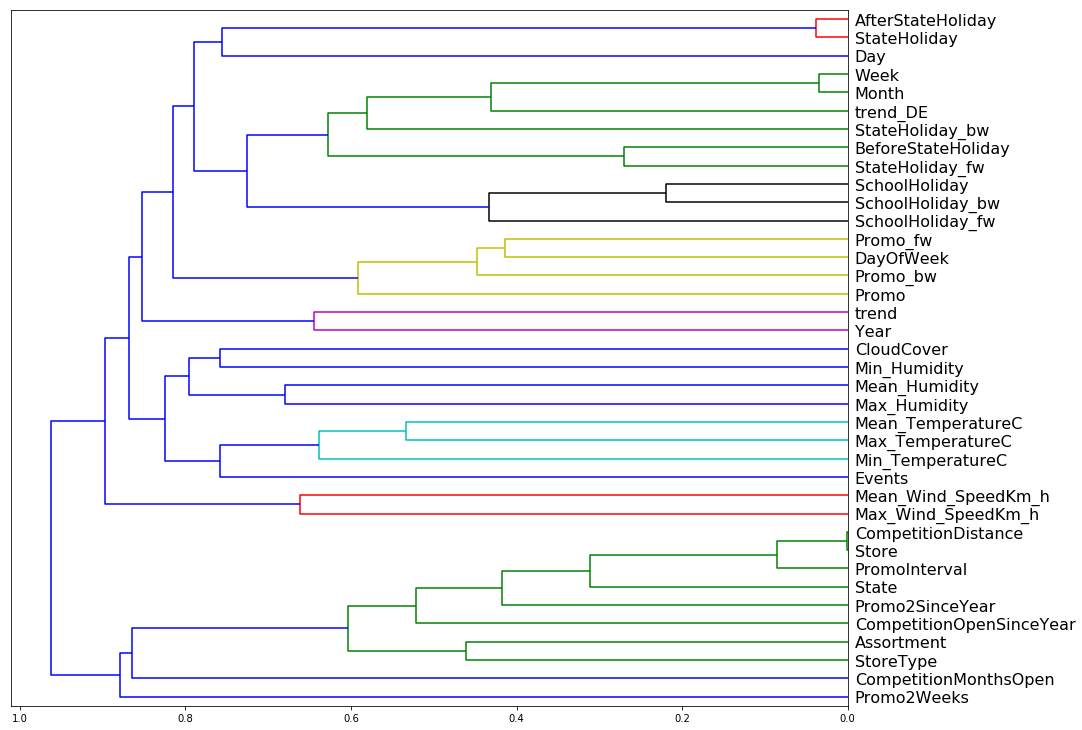

In [44]:
plot_dendrogram_corr(corr_v, df[all_vars].columns)

In [42]:
get_top_corr_dict(df[all_vars], corr_thr=0.9, corr_matr=corr_v)

OrderedDict([('Store vs CompetitionDistance', 1.0),
             ('Store vs StoreType', 0.999),
             ('Store vs Assortment', 0.999),
             ('Store vs PromoInterval', 0.999),
             ('Store vs CompetitionOpenSinceYear', 0.999),
             ('Store vs Promo2SinceYear', 0.999),
             ('Store vs State', 0.999),
             ('Month vs Week', 0.965),
             ('StateHoliday vs AfterStateHoliday', 0.962)])

That's an interesting case that one should use dendrogram as well as good all correlation list (or correlation matrix). You see that list tells us that Store vs PromoInterval correlate with each other very high, with is not seen on dendrogram.
Why is that?
Well looks like it's because Store and PromoInterval does correlate with each other extremely strongly, but pair Store+CompetitionDistance (which we can see on dendrogram) doesn't do that with PromoInterval.

I think it's a very interesting edge case

In [43]:
df_keep = apply_fill_n_catf(df, data_prep=data_pre)

And that what we will get if we will build dendrogram with Spearman rank-order correlation matrix.  
As we see it doesn't treat categorical columns well

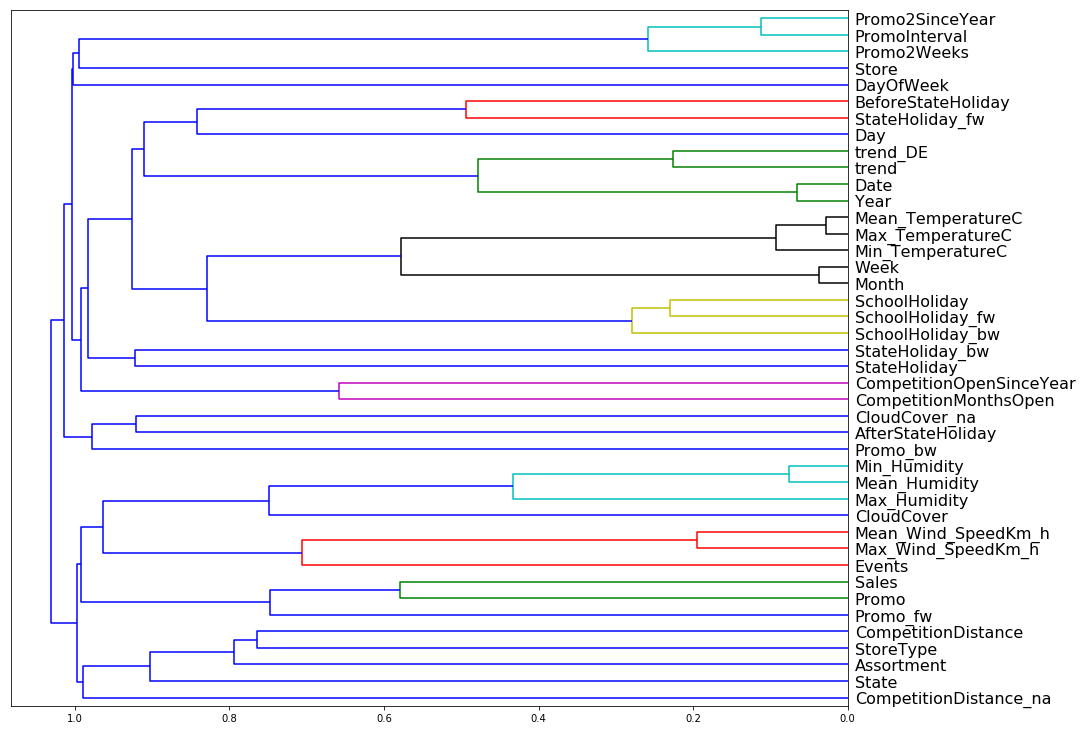

In [45]:
plot_dendrogram(df_keep, data_prep=data_pre)

In [46]:
get_top_corr_dict(df=df_keep[all_vars], corr_thr=0.8)

OrderedDict([('Max_TemperatureC vs Mean_TemperatureC', 0.972),
             ('Month vs Week', 0.962),
             ('Mean_TemperatureC vs Min_TemperatureC', 0.953),
             ('Mean_Humidity vs Min_Humidity', 0.925),
             ('PromoInterval vs Promo2SinceYear', 0.888),
             ('Max_TemperatureC vs Min_TemperatureC', 0.862),
             ('Max_Wind_SpeedKm_h vs Mean_Wind_SpeedKm_h', 0.805)])

## Features closeness and dimension reduction

The last thing we do is to visualize the embeddings vectors.   
For that we should reduce it's dimension to 2 as I wasn't able to plot 10-dimensions vector on a flat screen :)

In [27]:
from sklearn import manifold

In [28]:
def get_classes_o_list(data_prep:LabelLists):
    procs = data_prep.get_processors()[0][0]
    return procs.classes

def get_rev_emb_idxs(data_prep:LabelLists)->dict:
    classes_dict = get_classes_o_list(data_prep=data_prep)
    return {c:i for i, (c, _) in enumerate(classes_dict.items()) if (c[-3:] != "_na")}
    
    
def get_emb_outp(learn:Learner, field:str, inp:str, rev_emb_idxs:dict, classes, embs):
    emb = embs[rev_emb_idxs[field]]
    idx, = np.where(classes[field] == inp)
    if (len(idx) == 1):
        cat_idx = idx[0]
    else:
        cat_idx = 0
    return emb(torch.tensor(cat_idx, device=learn.data.device))
    

def get_embs_map(data_prep:LabelLists, learn:Learner)->OrderedDict:
    '''
    Output embedding vector for every item of every cafegirical column as a dictionary of dicts
    
    '''
    cat_cols = get_cat_cols(data_prep=data_prep, is_wo_na=True)
    rev_emb_idxs = get_rev_emb_idxs(data_prep=data_prep)    
    classes = get_classes_o_list(data_prep=data_prep)
    embs = learn.model.embeds
    learn.model.eval();
    result = OrderedDict()
    
    for cat in cat_cols:
        cat_res = OrderedDict()
        for val in classes[cat]:
            cat_res[val] = get_emb_outp(learn=learn,
                                        field=cat, inp=str(val), 
                                        rev_emb_idxs=rev_emb_idxs, 
                                        classes=classes, embs=embs)
        result[cat] = cat_res
        
    return result


def emb_map_reduce_dim(embs_map:OrderedDict, outp_dim:int=3, to_df:bool=True, method:str='pytorch', exclude:list=None):
    '''
    Reduces dimention of embedding map upto outp_dim
    Can use 'pytorch' approach (pca)
    or 'scilearn' for manifold.TSNE (longer, but not sure that it is better)
    '''
    exclude = listify(exclude)
    result = OrderedDict()
    for feat, val in emb_map.items():
        reformat = []
        names = []
        for k,v in val.items():
            reformat.append(v)
            names.append(k)
        reformat = torch.stack(reformat)
        if (exclude is not None) and (feat in exclude):
            continue
        if (method == 'scilearn'):
            tsne = manifold.TSNE(n_components=outp_dim, init='pca')
            reduced = tsne.fit_transform(to_np(reformat))
        else:
            reduced = reformat.pca(outp_dim)
        record = OrderedDict({k:v for k, v in zip(names, reduced)})
        result[feat] = record
    
    if (to_df == True):
        data = []
        for feat, val in result.items():
            for k,v in val.items():
                dt = list(v) if (method == 'scilearn') else list(to_np(v))
                data.append([feat] + [k]  + dt)
        names = ['feature', 'value'] + ['axis_' + str(i) for i in range(outp_dim)] 
        result = pd.DataFrame(data, columns=names)
    
    return result


def add_times_col(embs_map:DataFrame, df:DataFrame)->DataFrame:
    '''
    Adds to embeddings map dataframe new column with times of value's number of occurrences 
    Usefull for estimation of how accurate the value is (more time means more sure you can be)
    '''
    times = np.zeros(len(embs_map))
    last_feat = ''
    vc = None
    for i, (f, v) in enumerate(zip(embs_map['feature'], embs_map['value'])):
        if (f != last_feat):
            vc = df[f].value_counts(dropna=False)
            vc.index = vc.index.map(str)
            last_feat = f
        if (v != '#na#'):
            times[i] = vc[v]
        else:
            times[i] = vc['nan'] if ('nan' in vc.index) else 0
    result = embs_map.copy()
    result['times'] = times
    return result       

In [29]:
import pickle
# Little helpers for saving/loading variables with pickle
def sv_var(var, name):    
    f = open(path/f"{name}.pkl","wb")
    pickle.dump(var, f)
    f.close()
    
def ld_var(name):
    f = open(path/f"{name}.pkl","rb")
    var = pickle.load(f)
    f.close()
    return var

In [87]:
emb_map = get_embs_map(data_prep=data_pre, learn=learn)

In [88]:
redc_emb_map = emb_map_reduce_dim(embs_map=emb_map, outp_dim=2, to_df=True)

In [89]:
redc_emb_map = add_times_col(embs_map=redc_emb_map, df=df)

In [30]:
def plot_2d_emb(emb_map:DataFrame, feature:str, top_x:int=10):
    sub_df = emb_map.query(f"feature == '{feature}'").sort_values('times', ascending=False).head(top_x)
    X = sub_df['axis_0']
    Y = sub_df['axis_1']
    plt.figure(figsize=(15, 8))
    plt.scatter(X, Y)
    for name, x, y in zip(sub_df['value'], X, Y):
        plt.text(x, y, name, color=np.random.rand(3)*0.7, fontsize=11)
    plt.show()

We can see how the embeddings form a decent smooth curve from 1 to 12

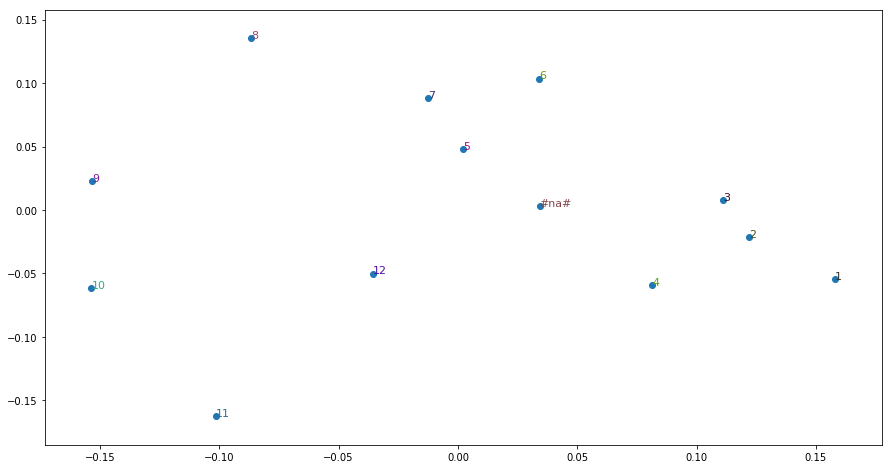

In [91]:
plot_2d_emb(emb_map=redc_emb_map, feature='Month', top_x=30)

In [229]:
redc_emb_map_scl = emb_map_reduce_dim(embs_map=emb_map, outp_dim=2, to_df=True, method='scilearn')

/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/decomposition/pca.py:535: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ / total_var.sum()
/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/decomposition/pca.py:535: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


In [230]:
redc_emb_map_scl = add_times_col(embs_map=redc_emb_map_scl, df=df)

Looks like `manifold.TSNE` is not as usefull as plain `pca`

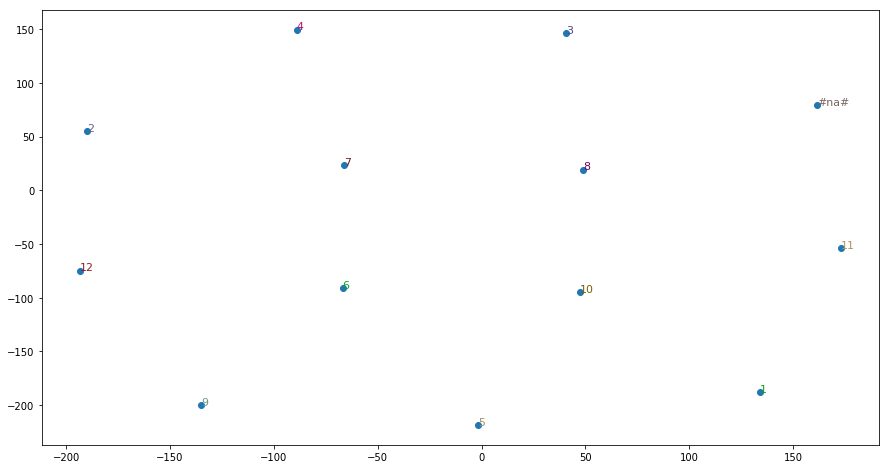

In [232]:
plot_2d_emb(emb_map=redc_emb_map_scl, feature='Month', top_x=30)